In [567]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

### 7. In the lab, we applied random forests to the Boston data using mtry=6 and using ntree=25 and ntree=500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for mtry and ntree. You can model your plot after Figure 8.10. Describe the results obtained.

In [166]:
boston_df = datasets.load_boston()
boston_df = pd.DataFrame(data=np.c_[boston_df['data'], boston_df['target']], columns= [c for c in boston_df['feature_names']] + ['Price'])

np.random.seed(1)
train = np.random.rand(len(boston_df)) < 0.5

display(boston_df.head())

# Create design and response matrix
f = 'Price ~ ' + ' + '.join(boston_df.columns.drop(['Price']))
y, X = pt.dmatrices(f, boston_df)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


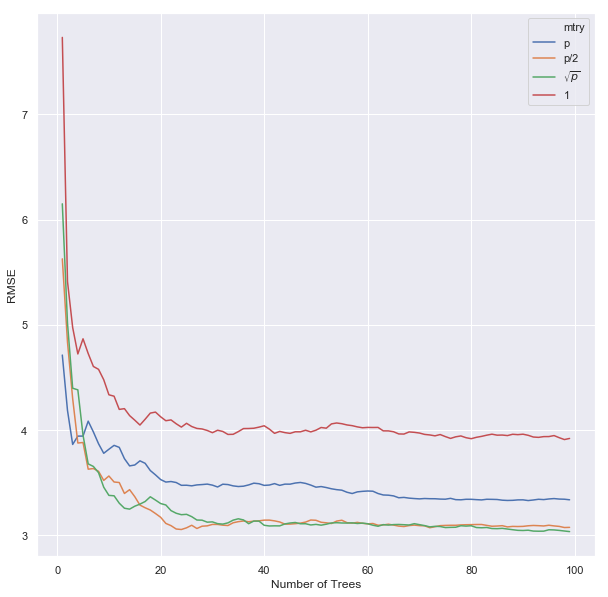

In [47]:
# Compare test RMSE of Random Forest for various numbers of features considered at each split (mtry)
# and increasing number of trees (ntree)

max_features = {'p': X.shape[1], 
                'p/2': int(np.around(X.shape[1]/2)),
                '$\sqrt{p}$': int(np.around(np.sqrt(X.shape[1]))),
                '1': 1} 

results = []
for mtry in max_features:
    for tree_count in np.arange(1, 100):
        regr   = RandomForestRegressor(max_features=max_features[mtry], random_state=0, n_estimators=tree_count)
        regr.fit(X[train], y[train])
        y_hat = regr.predict(X[~train])
        
        mse = metrics.mean_squared_error(y[~train], y_hat)
        rmse = np.sqrt(mse)
        results+= [[tree_count, mtry, rmse]]

plt.figure(figsize=(10,10))
sns.lineplot(x='Number of Trees', y='RMSE', hue='mtry', 
             data=pd.DataFrame(results, columns=['Number of Trees', 'mtry', 'RMSE']));

The above shows the test RMSE for a 50% holdout set where training set contains 240 observations each with 14 predictors.

We find that the test RMSE decreases with increasing number of trees for all values of mtry (number of random features considered at each split) 

The optimal value of m is less than p and greater than 1. In this case $m=\sqrt{p}$ yields the best results for $ntree > ?$ although $p/2$ performs better for some lower tree counts.

Incredibly the model does not seem prone to overfitting with test RMSE continuing to decrees up to ntree = 100.

### 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

#### (a) Split the data set into a training set and a test set.

#### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [246]:
carseats_df = pd.read_csv('./data/Carseats.csv')

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0
# Drop unused index
carseats_df = carseats_df.drop('Unnamed: 0', axis=1)

# Create index for training set
np.random.seed(1)
train = np.random.random(len(carseats_df)) > 0.5

display(carseats_df.head())

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [247]:
# Use all features excpet response features
# No intercept

preds = carseats_df.columns.drop(['Sales'])
#preds_scaled = ['standardize({})'.format(p) for p in preds]
f = 'Sales ~ 0 +' + ' + '.join(preds)
y, X = pt.dmatrices(f, carseats_df)
y = y.flatten()

# Fit Sklearn's tree regressor
clf = tree.DecisionTreeRegressor(max_depth=5).fit(X[train], y[train])

# Measure test set MSE
y_hat = clf.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE: {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))


Test MSE: 5.09
Test RMSE: 2.256


#### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

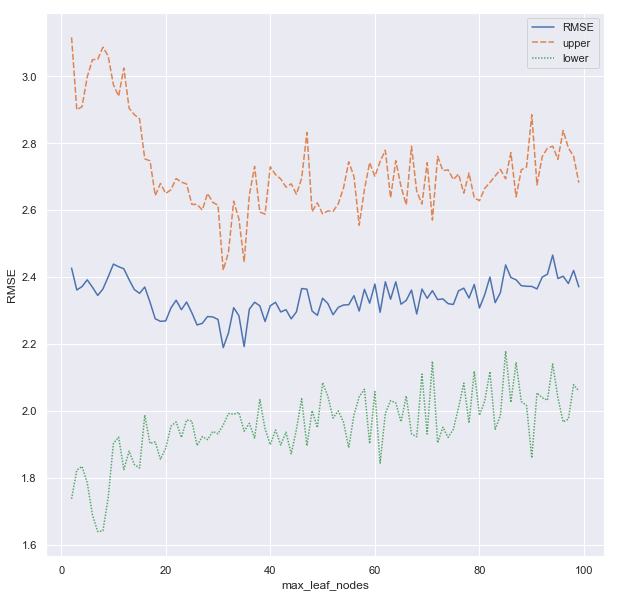

,RMSE,upper,lower
max_leaf_nodes,,,
31.0,2.188901,2.4201,1.957702


Test MSE : 4.661
Test RMSE: 2.159


In [248]:
# How about using CV to compare trees with different number of leaf nodes 
# as defined by the max_leaf_nodes parameter?

cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'upper', 'lower']

results = []
for m in np.arange(2, 100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(regr, X[train], y[train], cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)

# Use chosen model for test prediction
regr  = tree.DecisionTreeRegressor(max_leaf_nodes=int(chosen.index[0])).fit(X[train], y[train])
y_hat = regr.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

10-fold cross validation selects a pruned tree model that achieves test MSE of 4.524, an improvement on the unpruned model (5.066). Interestingly 100-fold, 5-fold and 2-fold CV were all unable to select an improvement on the unpruned model. 

#### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important.

In [109]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X.shape[1]
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(rmse, 3)))

Test MSE : 2.615
Test RMSE: 1.617


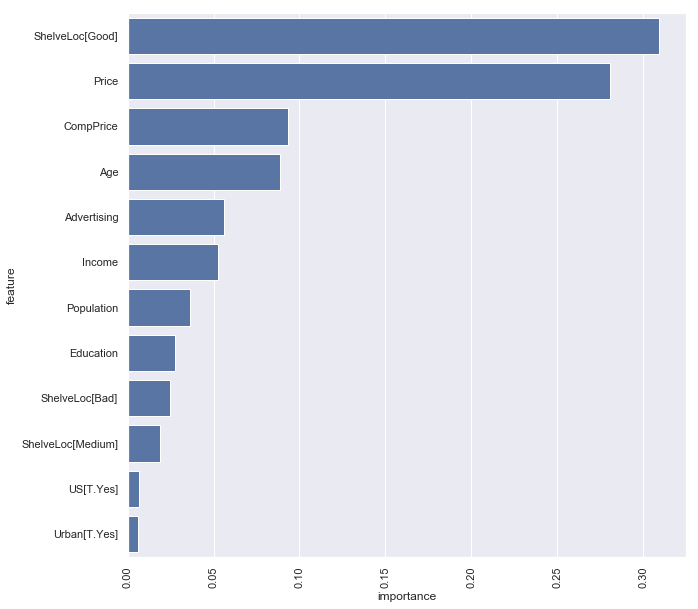

In [110]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

Bagging yields a significantly improved test MSE of 2.615 compared with 4.524 for the optimal pruned tree.

The bagging model indicates that instore Shelve Location (Good) and Price of the carseat are the most significant features affecting Sales revenue. This aligns with our observation when performing classification in hte lab.

#### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the importance() function to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [122]:
# Random Forest with 100 trees and 4 features considered at each split

max_features = 7
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 2.544
RMSE test: 1.595


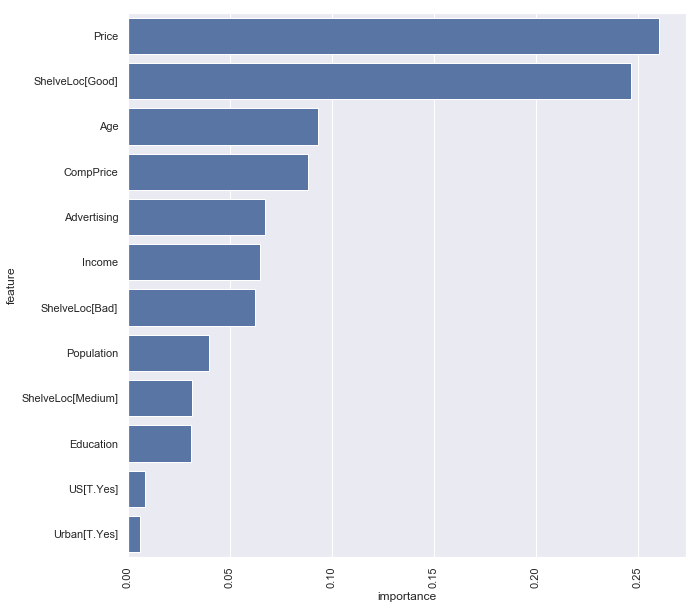

In [123]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

Random forest with 7 predictors at each split yields a test MSE 2.544 similar to bagging (2.615). A similar feature importance is ascribed.

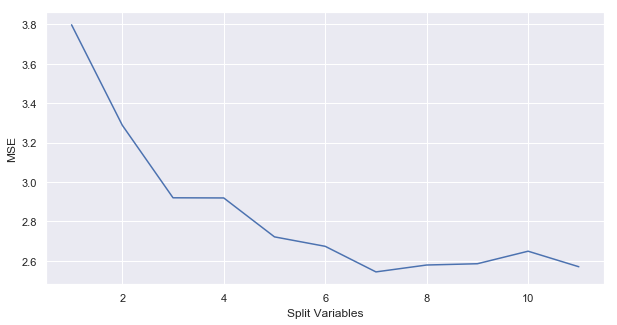

In [130]:
# Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

results = []
for max_features in np.arange(1, X.shape[1]):

    tree_count   = 100
    
    regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
    regr.fit(X[train], y[train])
    y_hat = regr.predict(X[~train])
    
    mse = metrics.mean_squared_error(y[~train], y_hat)
    rmse = np.sqrt(mse)
    
    results += [[max_features, mse]]

plt.figure(figsize=(10,5))
sns.lineplot(x='Split Variables', y='MSE', data=pd.DataFrame(results, columns=['Split Variables', 'MSE']));

## 9. This problem involves the OJ data set which is part of the ISLR package.

### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [251]:
oj_df = pd.read_csv('./data/oj.csv')
oj_df = oj_df.drop(oj_df.columns[0], axis=1)
display(oj_df.head())

# Index for Training set of 800
np.random.seed(1)
train_sample = np.random.choice(np.arange(len(oj_df)), size=800, replace=False)
train = np.asarray([(i in train_sample) for i in oj_df.index])

#oj_df.Purchase = oj_df.Purchase.map({'CH' : 1, 'MM': 0})
#oj_df.Store7 = oj_df.Store7.map({'Yes' : 1, 'No': 0})
#oj_df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


### (b) Fit a tree to the training data, with Purchase as the response and the other variables as predictors. Use the summary() function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [286]:
f = 'C(Purchase) ~ ' + ' + '.join(oj_df.columns.drop(['Purchase']))
y, X = pt.dmatrices(f, oj_df)
y = y[:, 0]

# Fit Sklearns tree classifier
clf = tree.DecisionTreeClassifier().fit(X[train], y[train])

print('training accuracy: {}'.format(np.around(clf.score(X[train], y[train]), 3)))
print('leaf nodes: 6')

training accuracy: 0.99
leaf nodes: 6


### (c) Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.

### (d) Create a plot of the tree, and interpret the results.

In [287]:
# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X.design_info.column_names, 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data) 
display(HTML(graph._repr_svg_()))

### (e) Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [288]:
# Here's the confusion matrix
print(confusion_matrix(y[~train], clf.predict(X[~train])))

test_err = 1 - clf.score(X[~train], y[~train])
print('\ntest error rate: {}'.format(np.around(test_err, 3)))

[[ 74  24]
 [ 40 132]]

test error rate: 0.237


### (f) Apply the cv.tree() function to the training set in order to determine the optimal tree size.

### (g) Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

### (h) Which tree size corresponds to the lowest cross-validated classification error rate?

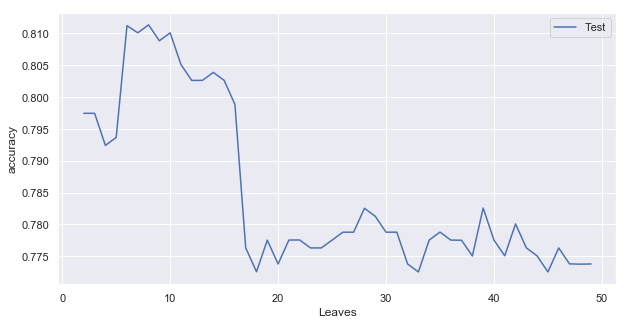

,Test
Leaves,
8.0,0.811304


In [308]:
# Estimate optimal tree with cross validation on training set

cv_folds = 10

results = []
for mln in np.arange(2, 50):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=mln)
    score = cross_val_score(clf, X[train], y[train], cv=cv_folds)
    results += [[mln, np.mean(score)]]


plt.figure(figsize=(10,5))
plot_df = pd.DataFrame(np.asarray(results), columns=['Leaves', 'Test']).set_index('Leaves')
sns.lineplot(data=plot_df);
plt.ylabel('accuracy')
plt.show();

display(HTML('<h4>Optimal tree size:</h4>'))
display(plot_df[plot_df['Test'] == plot_df['Test'].max()])

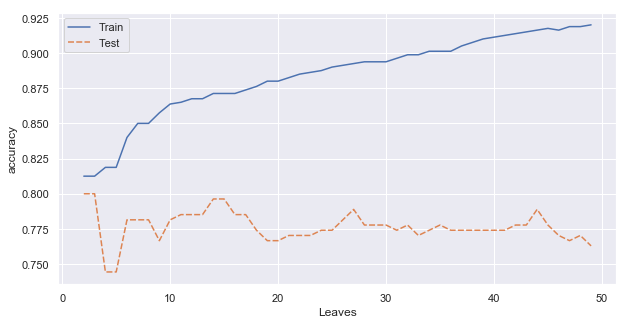

,Train,Test
Leaves,,
2.0,0.8125,0.8
3.0,0.8125,0.8


In [285]:
# Determine actual optimal tree using test set.

results = []
for mln in np.arange(2, 50):
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=mln).fit(X[train], y[train])

    accuracy_train = clf.score(X[train], y[train])  
    accuracy_test = clf.score(X[~train], y[~train])  
    results += [[mln, accuracy_train, accuracy_test]]

plt.figure(figsize=(10,5))
plot_df = pd.DataFrame(np.asarray(results), columns=['Leaves', 'Train', 'Test']).set_index('Leaves')
sns.lineplot(data=plot_df);
plt.ylabel('accuracy')
plt.show();

display(HTML('<h4>Optimal tree size:</h4>'))
display(plot_df[plot_df['Test'] == plot_df['Test'].max()])


### (i) Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

### (j) Compare the training error rates between the pruned and unpruned trees. Which is higher?

### (k) Compare the test error rates between the pruned and unpruned trees. Which is higher?

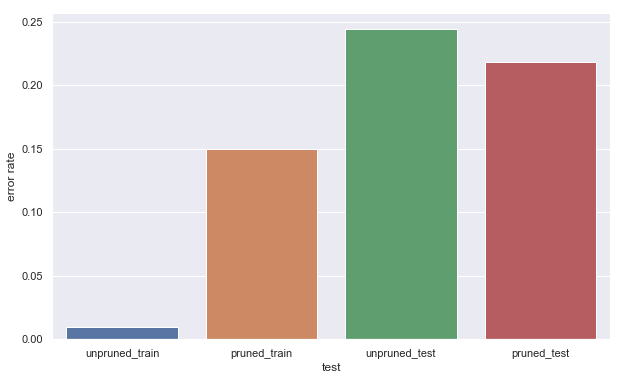

,test,error rate
0,unpruned_train,0.010000000000000009
1,pruned_train,0.15000000000000002
2,unpruned_test,0.24444444444444446
3,pruned_test,0.21851851851851856


In [326]:
clf_unpruned = tree.DecisionTreeClassifier().fit(X[train], y[train])
clf_pruned   = tree.DecisionTreeClassifier(max_leaf_nodes=8).fit(X[train], y[train])

scores = [['unpruned_train', 1 - clf_unpruned.score(X[train], y[train])],
          ['pruned_train', 1 - clf_pruned.score(X[train], y[train])],
          ['unpruned_test', 1 - clf_unpruned.score(X[~train], y[~train])],
          ['pruned_test', 1 - clf_pruned.score(X[~train], y[~train])]]

plot_df = pd.DataFrame(scores, columns=['test', 'error rate'])

plt.figure(figsize=(10, 6))
sns.barplot(x='test', y='error rate', data=plot_df)
plt.show();

display(plot_df)

The unpruned tree performs best in the training setting where as the pruned tree performs best in the test setting. This suggests that the unpruned tree is overfitting the training data leading to poor test score.

## 10. We now use boosting to predict Salary in the Hitters data set.

### (a) Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [341]:
hitters_df = pd.read_csv('./data/Hitters.csv')

# Drop null observations
hitters_df = hitters_df.dropna()
assert hitters_df.isnull().sum().sum() == 0

f = 'np.log(Salary) ~ ' + ' + '.join(hitters_df.columns.drop(['Salary']))
y, X = pt.dmatrices(f, hitters_df)

pd.DataFrame(X, columns=X.design_info.column_names).head()

,Intercept,League[T.N],Division[T.W],NewLeague[T.N],AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
0,1.0,1.0,1.0,1.0,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0
1,1.0,0.0,1.0,0.0,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0
2,1.0,1.0,0.0,1.0,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0
3,1.0,1.0,0.0,1.0,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0
4,1.0,0.0,1.0,0.0,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0


### (b) Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [346]:
# Index for Training set of 200
np.random.seed(1)
train_sample = np.random.choice(np.arange(len(hitters_df)), size=200, replace=False)
train = np.asarray([(i in train_sample) for i in hitters_df.index])

### (c) Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter λ. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

### (d) Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

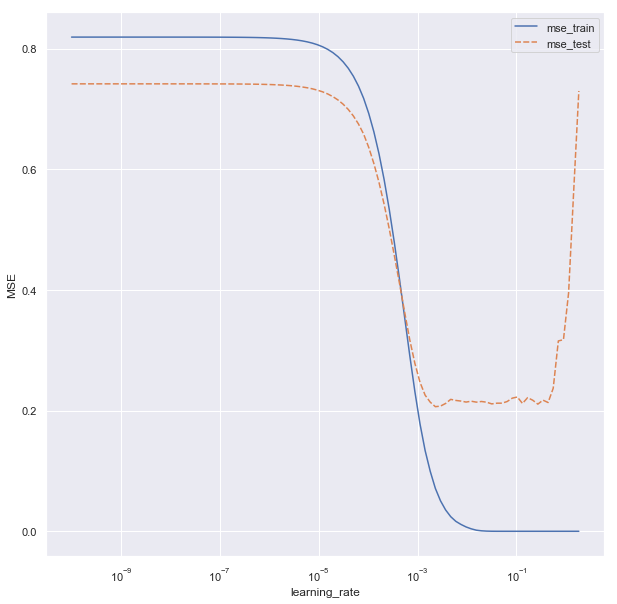

,mse_train,mse_test
learning_rate,,
0.00229,0.071057,0.206531


In [465]:
# Gradient boosting

max_features = 'auto'
tree_count   = 1000

# np.arange(0.0001, 1.2, 0.01)

results = []
for learning_rate in np.logspace(-10, np.log(1.3), 100): 
    regr   = GradientBoostingRegressor(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)
    regr = regr.fit(X[train], y[train])
    y_hat_train = regr.predict(X[train])
    y_hat_test  = regr.predict(X[~train])
    
    mse_train = metrics.mean_squared_error(y[train], y_hat_train)
    mse_test  = metrics.mean_squared_error(y[~train], y_hat_test)
    
    results += [[learning_rate, mse_train, mse_test]]

# Plot
df = pd.DataFrame(np.asarray(results), 
                  columns=['learning_rate', 'mse_train', 'mse_test']).set_index('learning_rate')
plt.figure(figsize=(10,10))
ax  = sns.lineplot(data=df)
ax.set_xscale('log')
plt.ylabel('MSE')
plt.show();

# Show best learning rate
display(df[df['mse_test'] == df['mse_test'].min()])

### (e) Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

In [446]:
# Naive ols
model = sm.OLS(y[train], X[train]).fit()
y_hat = model.predict(X[~train])

mse_test = metrics.mean_squared_error(y[~train], y_hat)
print('MSE test: {}'.format(np.around(mse_test, 3)))

MSE test: 0.455


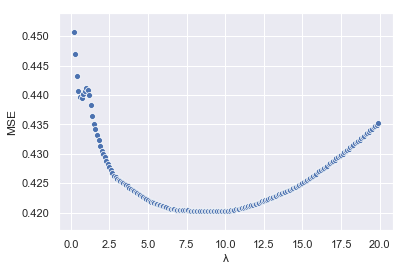

RMSE Train CV: 0.6482094156231718
@Lambda: 9.300000000000002
MSE test: 0.469
RMSE test: 0.685


In [463]:
def lasso_cv(X, y, λ, k):
    """Perform the lasso with 
    k-fold cross validation to return mean MSE scores for each fold"""
    # Split dataset into k-folds
    # Note: np.array_split doesn't raise excpetion is folds are unequal in size
    X_folds = np.array_split(X, k)
    y_folds = np.array_split(y, k)
    
    MSEs = []
    for f in np.arange(len(X_folds)):
        # Create training and test sets
        X_test  = X_folds[f]
        y_test  = y_folds[f]
        X_train = X.drop(X_folds[f].index)
        y_train = y.drop(y_folds[f].index)
        
        # Fit model
        model = Lasso(alpha=λ, copy_X=True, fit_intercept=True, max_iter=10000,
                      normalize=False, positive=False, precompute=False, random_state=0,
                      selection='cyclic', tol=0.0001, warm_start=False).fit(X_train, y_train)
        
        # Measure MSE
        y_hat = model.predict(X_test)
        #print(y_test)
        MSEs += [metrics.mean_squared_error(y_test, y_hat)]
    return MSEs

X_train = pd.DataFrame(X[train], columns=X.design_info.column_names)
y_train = pd.DataFrame(y[train], columns=['Price'])

#lambdas = np.arange(.000001, 0.01, .0001)

lambdas = np.arange(0.2, 20, .1)

MSEs    = [] 
for l in lambdas:
    MSEs += [np.mean(lasso_cv(X_train, y_train, λ=l, k=10))]

sns.scatterplot(x='λ', y='MSE', data=pd.DataFrame({'λ': lambdas, 'MSE': MSEs}))
plt.show();

# Choose model
lamb = min(zip(MSEs, lambdas))
print('RMSE Train CV: {}\n@Lambda: {}'.format(np.sqrt(lamb[0]), lamb[1]))


# Use chosen model on test set prediction
model = Lasso(alpha=lamb[1], copy_X=True, fit_intercept=True, max_iter=10000,
              normalize=False, positive=False, precompute=False, random_state=0,
              selection='cyclic', tol=0.0001, warm_start=False).fit(X[train], y[train])

y_hat = model.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

**Comment:**

Boosting yields a test MSE of 0.207, which is significantly better than naive OLS (0.455) and the Lasso (0.469). 

It is interesting that naive OLS with all features outperforms the lasso. This suggests that the lasso is unable to identify redundant features in the model.

### (f) Which variables appear to be the most important predictors in the boosted model?

0.20666656200483657


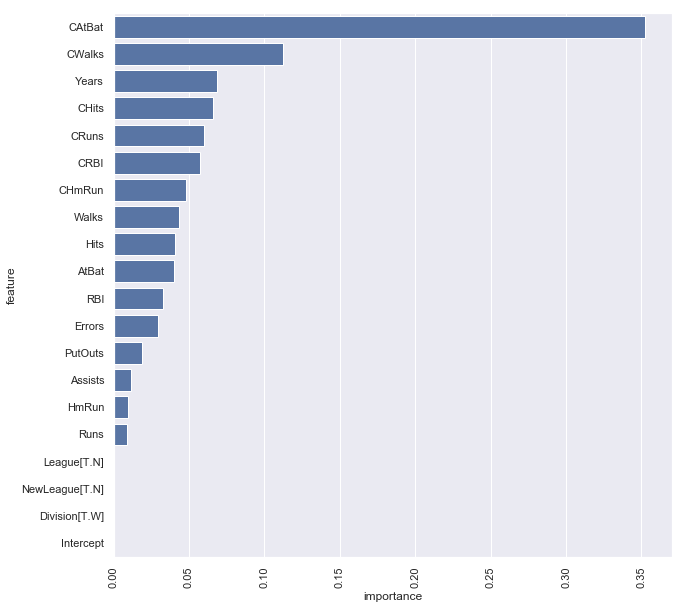

In [468]:
max_features = 'auto'
tree_count   = 1000
learning_rate = 0.00229

regr = GradientBoostingRegressor(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)

regr = regr.fit(X[train], y[train])
y_hat_test  = regr.predict(X[~train])

mse_test  = metrics.mean_squared_error(y[~train], y_hat_test)
print(mse_test)

# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

The boosting model suggests that CAtBat – Number of times at bat during his career – is by far the most important predictor of Salary. 

Number of walks during his career (CWalks) is also predictive of salary, but it seems likely that this feature would be covariant with CAtBat.

### (g) Now apply bagging to the training set. What is the test set MSE for this approach?

In [471]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X.shape[1]
tree_count   = 1000

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 0.208
RMSE test: 0.456


Bagging achieves a test MSE of 0.208 which is equivalent to that achieved by boosting. Bagging has the advantage here that the result was achived without need to tune hyper-parameters.

## 11. This question uses the Caravan data set.

### (a) Create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

In [518]:
caravan_df = pd.read_csv('./data/Caravan.csv').drop('Unnamed: 0', axis=1)

# Patsy feature processing
f = 'C(Purchase) ~ ' + ' + '.join(caravan_df.columns.drop(['Purchase']))
y, X = pt.dmatrices(f, caravan_df)
y = y[:, 1]

# Display processed features
display(pd.DataFrame(X, columns=X.design_info.column_names).head())

# Index for Training set of 1000
np.random.seed(1)
train_sample = np.random.choice(np.arange(len(caravan_df)), size=1000, replace=False)
train = np.asarray([(i in train_sample) for i in caravan_df.index])

,Intercept,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,1.0,33.0,1.0,3.0,2.0,8.0,0.0,5.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,37.0,1.0,2.0,2.0,8.0,1.0,4.0,1.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,37.0,1.0,2.0,2.0,8.0,0.0,4.0,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,9.0,1.0,3.0,3.0,3.0,2.0,3.0,2.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,40.0,1.0,4.0,2.0,10.0,1.0,4.0,1.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### (b) Fit a boosting model to the training set with Purchase as the response and the other variables as predictors. Use 1,000 trees, and a shrinkage value of 0.01. Which predictors appear to be the most important?

accuracy: 93.26%


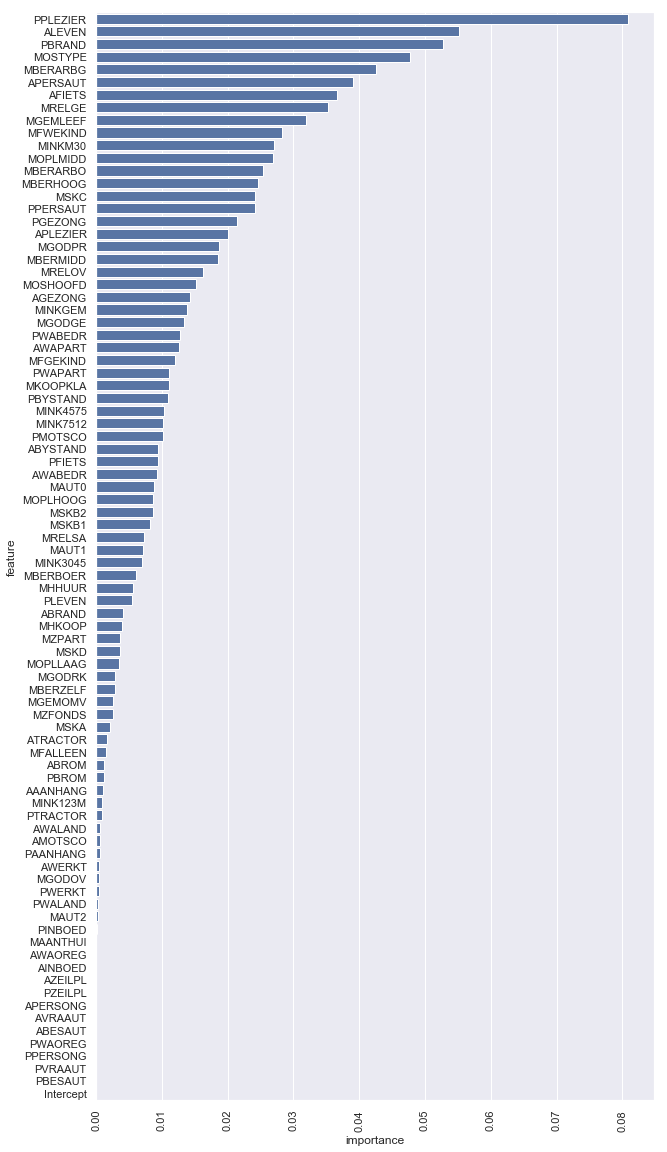

In [519]:
max_features = 'auto'
tree_count   = 1000
learning_rate = 0.01

model = GradientBoostingClassifier(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)

model = model.fit(X[train], y[train])
#y_hat_test  = regr.predict(X[~train])

accuracy = model.score(X[~train], y[~train])
print('accuracy: {}%'.format(np.around(accuracy*100, 2)))

# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': model.feature_importances_})

plt.figure(figsize=(10,20))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);

Here we use boosting to predict if someone purchases caravan insurance, a classification problem. The boosting model yields a test set prediction accuracy of 93.2%. 

The model suggests that the ten most important predictors are:

- PPLEIZER: Contribution boat policies
- ALEVAN: Number of life insurances
- PBRAND: Contribution fire policies
- MOSTYPE: Customer Subtype; see L0
- MBERARBG: Skilled labourers
- APERSAUT: Number of car policies
- AFIETS: Number of bicycle policies
- MRELGE: Married
- MGEMLEEF: Avg age
- MFWEKIND: Household with children

Broadly these predictors indicate whether customer has other insurance policies, and their level of family commitment e.g. married, with children.

We can't tell the direction in which these predictors are related with reposnse **Revision note:** is this possible in the boosting setting?

From tnis might hypothesise that customers who have already purchased insurance of other kinds are more inclined to purchase caravan insurance. Also, those with more family commitment and responsibility might also be more inclined to purchase insurance. It seems plausible that these two groups are more risk averse.

### (c) Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20 %. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [575]:
max_features = 'auto'
tree_count   = 1000
learning_rate = 0.01

model = GradientBoostingClassifier(max_features=max_features, 
                                       random_state=1, 
                                       n_estimators=tree_count,
                                       learning_rate=learning_rate)

model = model.fit(X[train], y[train])
#y_hat_test  = regr.predict(X[~train])


# Boosting stats
threshold = 0.2
y_hat_proba = model.predict_proba(X[~train])
y_hat = (y_hat_proba[:, 1] > threshold).astype(np.float64)
confusion_mat = confusion_matrix(y[~train], y_hat)

# What fraction of the people predicted to make a purchase do in fact make one?
pos_pred_val = np.around(confusion_mat[:, 1][1] / np.sum(confusion_mat[:, 1]), 5)

display(HTML('<h4>BOOSTING: Confusion matrix</h4>'))
print(confusion_mat)

print('\nPositive Predictive Value: {}'.format(pos_pred_val))

[[4405  120]
 [ 266   31]]

Positive Predictive Value: 0.2053


In [576]:
# KNN

# PREDICT
for K in range(1, 10):
    # model
    model = KNeighborsClassifier(n_neighbors=K).fit(X[train], y[train])
    # Predict
    y_pred = model.predict(X[~train])
    
    # Confusion table
    display(HTML('<h3>K={}</h3>'.format(K)))
    confusion_mtx = confusion_matrix(y[~train], y_pred)
    print(confusion_mtx)
    
    ## Classifier stats
    pos_pred_val = np.around(confusion_mtx[:, 1][1] / np.sum(confusion_mtx[:, 1]), 5)
    print('\nPositive Predictive Value: {}'.format(pos_pred_val))

[[4280  245]
 [ 274   23]]

Positive Predictive Value: 0.08582


[[4507   18]
 [ 293    4]]

Positive Predictive Value: 0.18182


[[4476   49]
 [ 288    9]]

Positive Predictive Value: 0.15517


[[4524    1]
 [ 297    0]]

Positive Predictive Value: 0.0


[[4522    3]
 [ 297    0]]

Positive Predictive Value: 0.0


[[4525    0]
 [ 297    0]]

Positive Predictive Value: nan


[[4525    0]
 [ 297    0]]

Positive Predictive Value: nan


[[4525    0]
 [ 297    0]]

Positive Predictive Value: nan


[[4525    0]
 [ 297    0]]

Positive Predictive Value: nan


**Comment:** KNN performs best when k=2 achieving a Positive Predictive Value of 0.182, which is slightly worse but not disimilar to the boosting result (0.205). The boosting model also excels in achieving roughly 8 times more True Positive predictions, so we would certainly choose the boosting model in this case.

It is worth noting that the dataset in this setting is highly dimensional with over 80 predictors, so the effectiveness of KNN is likely hindered by the curse of dimensionality.

## 12. Apply boosting, bagging, and random forests to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

# TODO: I'd like to do this using the kaggle house prices dataset